In [1]:
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from PIL import Image
import matplotlib.pyplot as plt
from skimage import util
import sys
import ipywidgets as widgets
import IPython.display as display

Resolution of Image:  (964, 1280) 

Image:


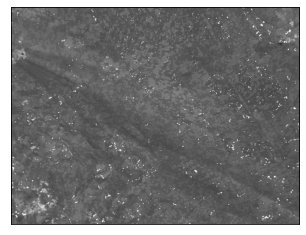

In [2]:
img_in = np.array(Image.open('../data/test_kmeans.tif').convert('L'))
print("Resolution of Image: ", img_in.shape, "\n")
print("Image:")
imgplot = plt.imshow(img_in, cmap='gray')
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)

In [3]:
def pad(img,wsize,stride=1):
    height,width = img.shape
    if stride == 'block':
        adj = 0
        stride = wsize
    else:
        adj = 1

    px = wsize - height % stride - adj
    if px % 2 == 0:
        px = int(px/2)
        px = (px,px)
    else:
        px = int((px-1)/2)
        px = (px,px+1)

    py = wsize - width % stride - adj
    if py % 2 == 0:
        py = int(py/2)
        py = (py,py)
    else:
        py = int((py-1)/2)
        py = (py,py+1)

    return np.pad(img,pad_width=(px,py),mode='symmetric')

In [4]:
wsize = 30
n_clusters = 5
stride = 3
seed = 197208

In [5]:
kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=seed)

# img_in = img

X = util.view_as_windows(
    pad(img_in,wsize=wsize,stride=stride),
    window_shape=(wsize,wsize),
    step=stride)

mask_dim = X.shape[:2]
X=X.reshape(-1,wsize**2)

kmeans = kmeans.fit(X)

In [6]:
mb_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=seed)

# img_in = img

mb_X = util.view_as_windows(
    pad(img_in,wsize=wsize,stride=stride),
    window_shape=(wsize,wsize),
    step=stride)

mb_mask_dim = mb_X.shape[:2]
mb_X=mb_X.reshape(-1,wsize**2)

mb_kmeans = mb_kmeans.fit(mb_X)

In [7]:
np.set_printoptions(threshold=10)

mask = kmeans.labels_.reshape(*mask_dim)
mask = Image.fromarray(mask)

mb_mask = mb_kmeans.labels_.reshape(*mb_mask_dim)
mb_mask = Image.fromarray(mb_mask)

In [8]:
clusters = np.array(mask.resize(img_in.shape[::-1])).astype(np.uint8)+1
mb_clusters = np.array(mb_mask.resize(img_in.shape[::-1])).astype(np.uint8)+1

mb_clusters

array([[5, 5, 5, ..., 4, 4, 4],
       [5, 5, 5, ..., 4, 4, 4],
       [5, 5, 5, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 3, 3, 3],
       [4, 4, 4, ..., 3, 3, 3],
       [4, 4, 4, ..., 3, 3, 3]], dtype=uint8)

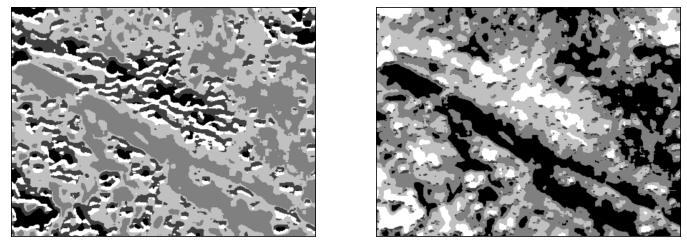

In [17]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,16))
#fig = plt.figure(figsize=(240,320))
ax[0].imshow(clusters, cmap='gray');
ax[1].imshow(mb_clusters, cmap='gray');

ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)
ax[1].axes.get_xaxis().set_visible(False)
ax[1].axes.get_yaxis().set_visible(False)

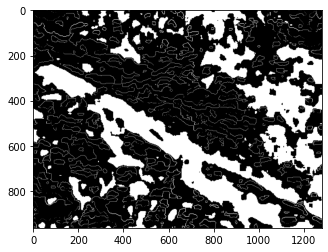

In [22]:
region_1 = np.where(clusters == 3, 1,0)
plt.imshow(region_1, cmap='gray')

# Varying Parameters

### Define function that runs mini-match k-means and returns array

In [11]:
def mbkmeans(n_clusters,seed,stride,wsize):
    mb_kmeans = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=seed)

    mb_X = util.view_as_windows(
        pad(img_in,wsize=wsize,stride=stride),
        window_shape=(wsize,wsize),
        step=stride)

    mb_mask_dim = mb_X.shape[:2]
    mb_X=mb_X.reshape(-1,wsize**2)

    mb_kmeans = mb_kmeans.fit(mb_X)
    
    mb_mask = mb_kmeans.labels_.reshape(*mb_mask_dim)
    mb_mask = Image.fromarray(mb_mask)
    
    mb_clusters = np.array(mb_mask.resize(img_in.shape[::-1])).astype(np.uint8)+1
    return mb_clusters 

### Vary the number of clusters: 

Text(0.5, 1.0, 'original')

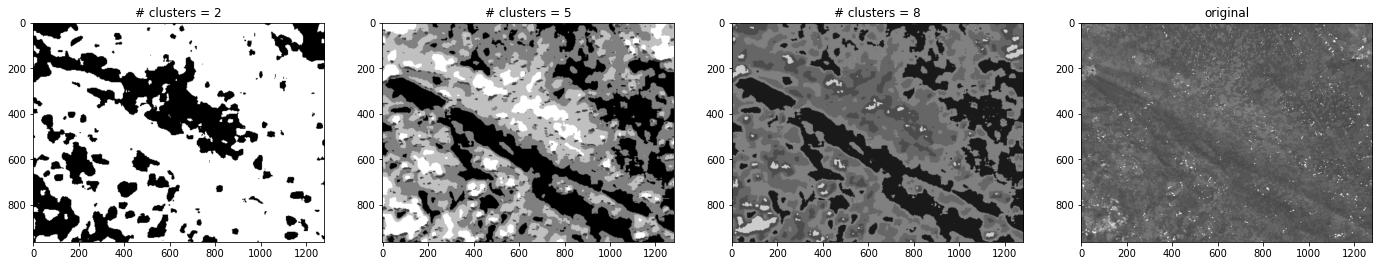

In [12]:
wsize = 30
nclusters = [2, 5, 8]
stride = 3
seed = 197208

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(24,6))
for iter, ncl in enumerate(nclusters):
    mb_cluster=mbkmeans(ncl,seed,stride,wsize)
    ax[iter].imshow(mb_cluster, cmap='gray');
    ax[iter].set_title('# clusters = %i' %ncl)
ax[3].imshow(img_in, cmap='gray')
ax[3].set_title('original')

### Vary stride:

Text(0.5, 1.0, 'original')

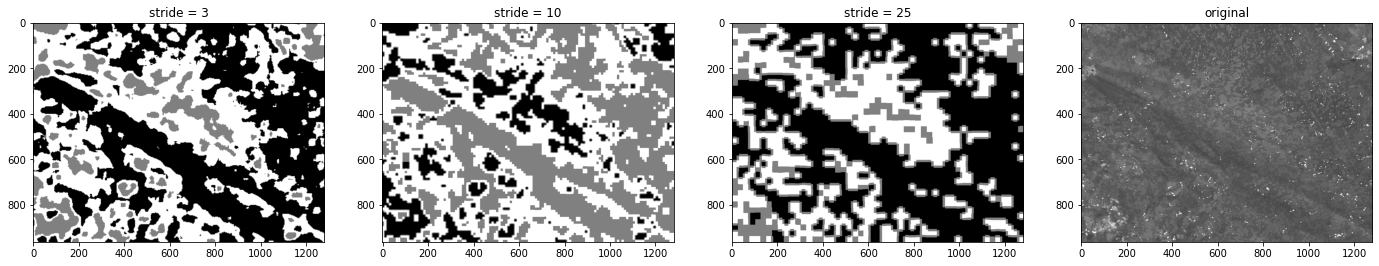

In [13]:
wsize = 30
nclusters = 3
stride = [3,10,25]
seed = 197208

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(24,6))
for iter, nst in enumerate(stride):
    mb_cluster=mbkmeans(nclusters,seed,nst,wsize)
    ax[iter].imshow(mb_cluster, cmap='gray');
    ax[iter].set_title('stride = %i' %nst)
ax[3].imshow(img_in, cmap='gray')
ax[3].set_title('original')

### Vary wsize:

Text(0.5, 1.0, 'original')

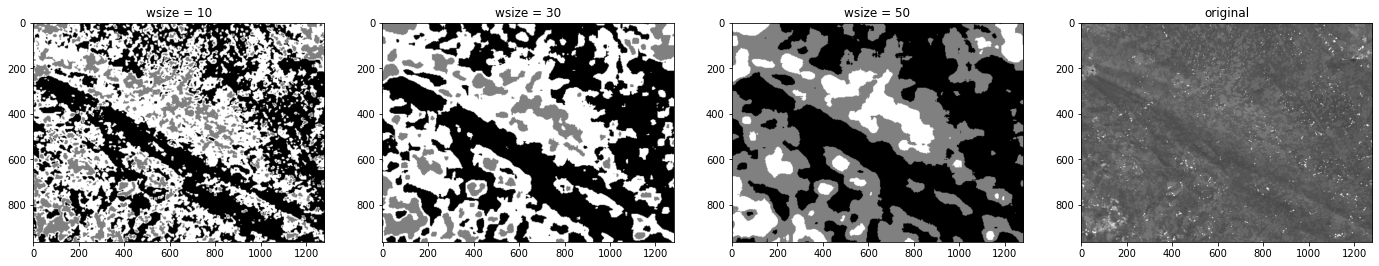

In [14]:
wsize = [10,30,50]
nclusters = 3
stride = 3
seed = 197208

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(24,6))
for iter, nws in enumerate(wsize):
    mb_cluster=mbkmeans(nclusters,seed,stride,nws)
    ax[iter].imshow(mb_cluster, cmap='gray');
    ax[iter].set_title('wsize = %i' %nws)
ax[3].imshow(img_in, cmap='gray')
ax[3].set_title('original')